In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Configurar semente para reprodutibilidade
np.random.seed(42)

# Criar dados simulados
n = 100  # Número de observações
velocidade = np.random.normal(60, 10, n)  # Velocidade média (em km/h)
sinalizacao = np.random.binomial(1, 0.4, n)  # 0 ou 1 (ausência ou presença)

# Calcular lambda (média da Poisson) com efeitos das variáveis
log_lambda = 0.5 + 0.03 * velocidade + 0.8 * sinalizacao
lambda_ = np.exp(log_lambda)

# Gerar contagem de acidentes (variável resposta)
acidentes = np.random.poisson(lambda_)

# Criar DataFrame
df = pd.DataFrame({"acidentes": acidentes, "velocidade": velocidade, "sinalizacao": sinalizacao})
print(df.head())

   acidentes  velocidade  sinalizacao
0         15   64.967142            0
1          7   58.617357            0
2         18   66.476885            0
3         13   75.230299            0
4         26   57.658466            1


In [2]:
# Definir variáveis explicativas (X) e resposta (y)
X = df[["velocidade", "sinalizacao"]]
X = sm.add_constant(X)  # Adicionar intercepto (beta_0)
y = df["acidentes"]

# Ajustar modelo
modelo_poisson = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              acidentes   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -281.85
Date:                Thu, 27 Mar 2025   Deviance:                       121.52
Time:                        15:55:01   Pearson chi2:                     119.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9728
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5355      0.181      2.967      

In [3]:
# Calcular média e variância da variável resposta
print(f"Média de acidentes: {np.mean(acidentes)}")
print(f"Variância de acidentes: {np.var(acidentes)}")

# Razão variância/média (se >>1, indica sobredispersão)
print(f"Razão variância/média: {np.var(acidentes)/np.mean(acidentes)}")

Média de acidentes: 15.57
Variância de acidentes: 76.4451
Razão variância/média: 4.9097687861271675


In [4]:
# Prever para velocidade=65 km/h e sinalizacao=1
novos_dados = [1, 65, 1]  # [const, velocidade, sinalizacao]
lambda_pred = np.exp(modelo_poisson.predict(novos_dados))
print(f"Contagem prevista de acidentes: {lambda_pred[0]}")

Contagem prevista de acidentes: 223709907183.715


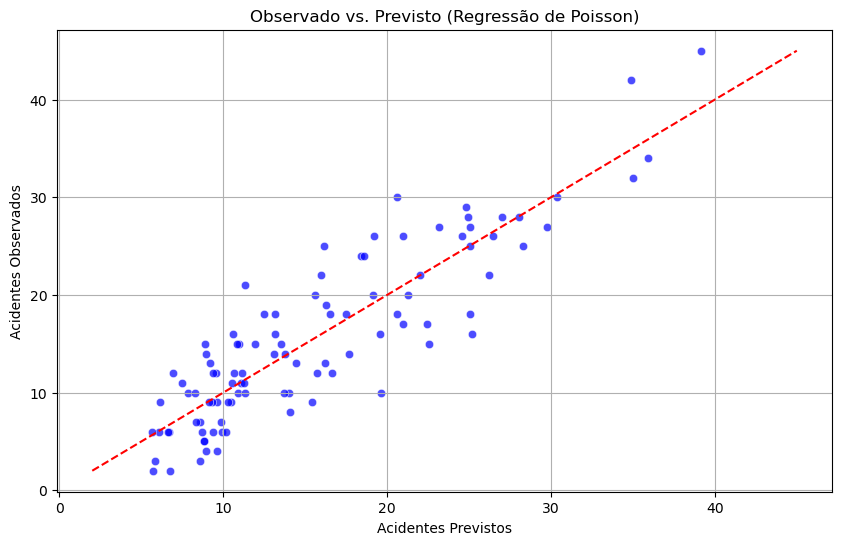

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular valores previstos pelo modelo
df['previsto'] = modelo_poisson.predict()

# Plotar observado vs. previsto
plt.figure(figsize=(10, 6))
sns.scatterplot(x='previsto', y='acidentes', data=df, alpha=0.7, color='blue')
plt.plot([df['acidentes'].min(), df['acidentes'].max()], [df['acidentes'].min(), df['acidentes'].max()], 'r--')  # Linha de referência (y=x)
plt.title('Observado vs. Previsto (Regressão de Poisson)')
plt.xlabel('Acidentes Previstos')
plt.ylabel('Acidentes Observados')
plt.grid(True)
plt.show()

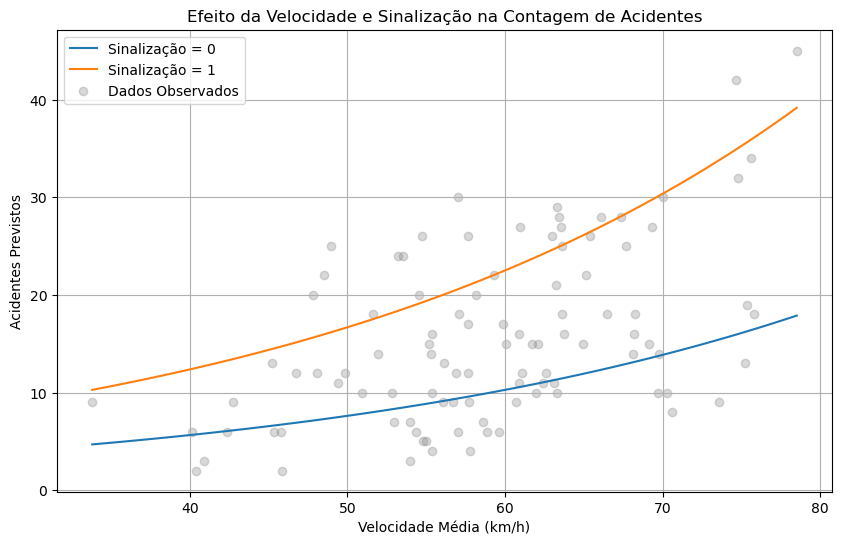

In [6]:
# Criar grid de valores para previsão
velocidade_grid = np.linspace(df['velocidade'].min(), df['velocidade'].max(), 100)
sinalizacao_values = [0, 1]  # Ausência e presença

# Prever para cada combinação
plt.figure(figsize=(10, 6))
for sinal in sinalizacao_values:
    X_grid = pd.DataFrame({'const': 1, 'velocidade': velocidade_grid, 'sinalizacao': sinal})
    y_grid = modelo_poisson.predict(X_grid)
    plt.plot(velocidade_grid, y_grid, label=f'Sinalização = {sinal}')

plt.scatter(df['velocidade'], df['acidentes'], color='gray', alpha=0.3, label='Dados Observados')
plt.title('Efeito da Velocidade e Sinalização na Contagem de Acidentes')
plt.xlabel('Velocidade Média (km/h)')
plt.ylabel('Acidentes Previstos')
plt.legend()
plt.grid(True)
plt.show()

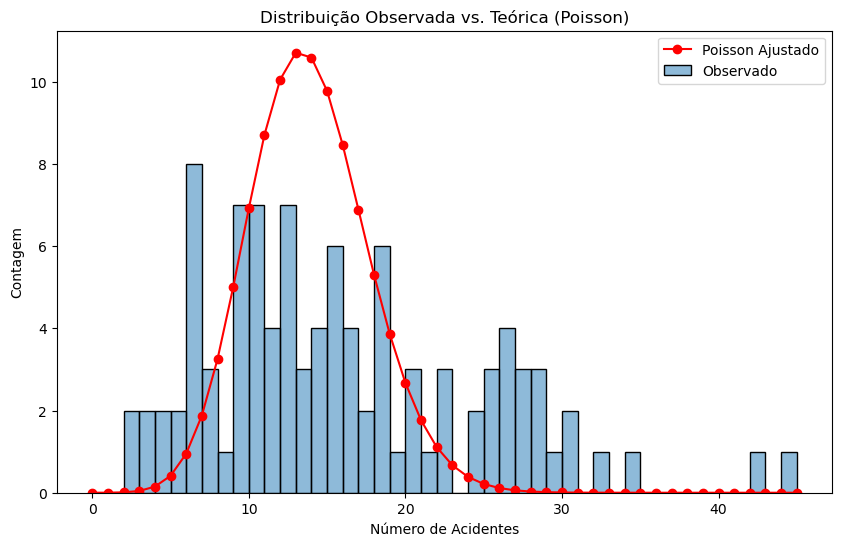

In [7]:
from scipy.stats import poisson

# Parâmetro lambda médio do modelo
lambda_medio = np.exp(modelo_poisson.params['const'] + 
                    modelo_poisson.params['velocidade'] * df['velocidade'].mean() + 
                    modelo_poisson.params['sinalizacao'] * df['sinalizacao'].mean())

# Gerar valores teóricos de Poisson
x_teorico = np.arange(0, df['acidentes'].max() + 1)
y_teorico = poisson.pmf(x_teorico, lambda_medio) * len(df)

# Plotar
plt.figure(figsize=(10, 6))
sns.histplot(df['acidentes'], bins=x_teorico, stat='count', alpha=0.5, label='Observado')
plt.plot(x_teorico, y_teorico, 'ro-', label='Poisson Ajustado')
plt.title('Distribuição Observada vs. Teórica (Poisson)')
plt.xlabel('Número de Acidentes')
plt.ylabel('Contagem')
plt.legend()
plt.show()